In [2]:
import torch 
import matplotlib.pyplot as plt
import numpy as np

from utils import train_batch_step, retrieve_training_params, retrieve_setup


In [3]:
# ----------- evaluation ---------------
def eval(model, dataset):
    """
    Evaluate model.

    Parameters:
    ----------
    model: pytorch.Model
        Model.

    dataset: pytorch.Dataset
        Dataset.

    loss_fn: pytorch.Functional
        Loss function.

    Returns:
    -------
    output: dict
        Dictionary of {metric:value}. 
    """
    device = next(model.parameters()).device
    data_loader = torch.utils.data.DataLoader(dataset, 200)

    model.eval()
    with torch.no_grad():
        loss, acc, n_samples = 0, 0, 0

        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)
            loss += torch.nn.functional.cross_entropy(y_pred, y_batch, reduction="sum")   # if not classification task this is going to raise an error

            _, y_pred = torch.max(y_pred, 1)
            acc += (y_pred == y_batch).sum()

            n_samples += y_batch.size(0) 

    loss = loss.item() / n_samples 
    acc = acc.item() / n_samples * 100

    return dict(loss=loss, acc=acc)


# ---------------- train ------------------------------
def train(X_batch, y_batch, model, optimizer, loss_fn):
    """
    Train for one iteration.

    Parameters:
    ----------
    X_batch: pytorch.Tensor
        Batch of data.

    y_batch: pytorch.Tensor
        Labels of data.

    model: pytorch.Model
        Model.

    optimizer: pytorch.Optimizer
        Optimizer.

    loss_fn: pytorch.Functional 
        Loss function. 

    Returns:
    -------
    loss: float
        Loss.
    """
    device = next(model.parameters()).device
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    model.train()

    # forward
    y_pred = model(X_batch)
    loss = loss_fn(y_pred, y_batch)

    # backward
    optimizer.zero_grad()
    loss.backward()

    # update
    optimizer.step()

    return loss.item()


def training_loop(model, dataset, scheduler, from_file=None, optimizer=None, loss_fn=None, 
          n_epochs=None, batch_size=None, train_strategy=("", 1), test_strategy=("", 1),
          scheduler_strategy="iter", device="cpu"):
    """
    Train model over multiple iterations.

    Parameters:
    ----------
    model: pytorch.Model
        Model.
    
    dataset: dict
        Dataset:
            "train": pytorch.Dataset
                Training data.
            "test": pytorch.Dataset
                Test data.

    scheduler: pytorch.Scheduler
        Scheduler.

    optimizer: pytorch.Optimizer
        Optimizer.

    loss_fn: pytorch.Functional
        Loss function.

    n_epochs: int
        Number of epochs.

    batch_size: int
        Number of samples per batch.

    train_strategy: tuple(str, int)
        Strategy to evaluate training data. The first elment should be 
        a string ('iter' or 'epoch') indicating wether the evaluation 
        should be done every N iteration or N epoch. The second element
        should be an integer indicating N.

    test_strategy: tuple(str, int)
        Strategy to evaluate test data. See train_strategy.

    scheduler_strategy: str
        Scheduler strategy, either 'iter' or 'epoch. Indicates if the 
        scheduler should be updated each epoch or each iteration.

    device: str
        Device ('cpu' or 'cuda') on which to run the model.
    """
    # data loader
    data_loader = torch.utils.data.DataLoader(dataset["train"], batch_size, shuffle=True)

    # storage
    losses = []
    metrics = dict(
        train={"loss":[], "acc":[]}, 
        test={"loss":[], "acc":[]}
    )

    # train/test strategy
    i_epoch = len(data_loader)

    if train_strategy[0] == "iter":
        check_eval_train = lambda i,e: i % train_strategy[1] == 0
    elif train_strategy[0] == "epoch":
        check_eval_train = lambda i, e: (i % i_epoch == 0) and (e % train_strategy[1] == 0)
    else:
        check_eval_train = lambda i, e: False 

    if test_strategy[0] == "iter":
        check_eval_test = lambda i, e: i % test_strategy[1] == 0
    elif test_strategy[0] == "epoch":
        check_eval_test = lambda i, e: (i % i_epoch == 0) and (e % test_strategy[1] == 0)
    else:
        check_eval_test = lambda i, e: False

    # training
    model.to(device)
    for epoch in range(n_epochs):
        for i, (X_batch, y_batch) in enumerate(data_loader):

            # train with batch
            loss = train_batch_step(X_batch, y_batch, model, optimizer, loss_fn)
            losses.append(loss)

            # measure metrics
            if check_eval_train(i+1, epoch) == True:
                m = eval(model, dataset["train"])
                metrics["train"]["loss"].append(m["loss"])
                metrics["train"]["acc"].append(m["acc"])
            if check_eval_test(i+1, epoch) == True:
                m = eval(model, dataset["test"])
                metrics["test"]["loss"].append(m["loss"])
                metrics["test"]["acc"].append(m["acc"])

            # update scheduler
            #if scheduler_strategy == "iter":
            #    scheduler.step()

        #if scheduler_strategy == "epoch":
        #    scheduler.step()

    losses = np.array(losses)

    return model, losses, metrics

In [4]:
# Download model and dataset
model, dataset = retrieve_setup("MobileNetV3Small", "CIFAR10")
_, l, metrics = training_loop(
    model, 
    dataset, 
    "bunny", 
    from_file="parameters.yml",
    test_strategy=("epoch", 1),
    device="cuda",
)


Files already downloaded and verified
Files already downloaded and verified
Epoch: 0, Iter: 2/98, Loss: 11.1924


AttributeError: 'str' object has no attribute 'step'

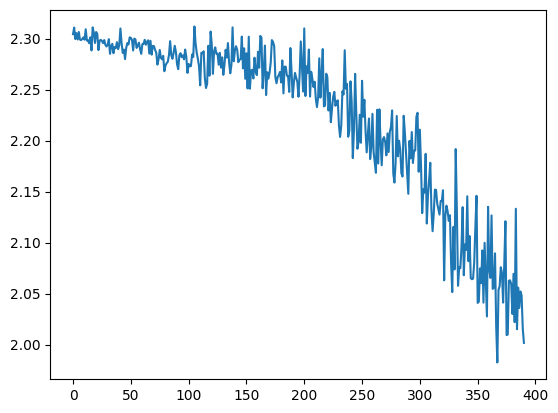

In [7]:
import numpy as np 

plt.plot(_)
plt.show()